<a href="https://colab.research.google.com/github/fxlmer/JSTP22_Skin-Diseases-Classification-Using-Machine-Learning/blob/master/Ex3_PJ61403_DenseNet121_ClassWeights_Ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [1]:
!nvidia-smi

Sun Feb 21 14:27:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from pj61403_utils_functions import *

In [3]:
tf.compat.v1.disable_eager_execution()

# Hyperparameters

In [41]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

EPOCHS = 100
NUM_CLASSES = 4
BATCH_SIZE = 32

LR = 1e-4

# Data

## Clone Data

In [5]:
!git clone https://github.com/EvilPickle-PCSHSPT/PJ61403_DATA_split_50-25-25

Cloning into 'PJ61403_DATA_split_50-25-25'...
remote: Enumerating objects: 3962, done.
remote: Counting objects: 100% (3962/3962), done.
remote: Compressing objects: 100% (3659/3659), done.
remote: Total 4366 (delta 261), reused 3960 (delta 261), pack-reused 404
Receiving objects: 100% (4366/4366), 167.13 MiB | 24.60 MiB/s, done.
Resolving deltas: 100% (278/278), done.
Checking out files: 100% (5061/5061), done.


In [6]:
train_dir = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/train'

val_dir = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/val'

test_dir = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/test'

## Data Augmentation

In [7]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_aug.flow_from_directory(directory=train_dir,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode ='categorical')

val_generator = val_aug.flow_from_directory(directory=val_dir,
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                class_mode='categorical')

test_generator = test_aug.flow_from_directory(directory=test_dir,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None)

Found 121 images belonging to 4 classes.
Found 60 images belonging to 4 classes.
Found 63 images belonging to 4 classes.


# Model

## Base Model

In [11]:
!git clone https://github.com/fxlmer/JSTP22_Skin-Diseases-Classification-Using-Machine-Learning

fatal: destination path 'JSTP22_Skin-Diseases-Classification-Using-Machine-Learning' already exists and is not an empty directory.


In [12]:
base_model = tf.keras.models.load_model('/content/JSTP22_Skin-Diseases-Classification-Using-Machine-Learning/PJ61403_work_Ver2/Ex2/model_weights/HAM10000_DenseNet121_ClassWeights_Ver2_model.h5')

In [13]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

## New Model

In [14]:
num_layers = len(base_model.layers)

In [15]:
for i in range(num_layers):
    base_model.layers[i].trainable = False

x = base_model.layers[num_layers-2].output
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.25)(x)
prediction = Dense(4, activation='softmax')(x)

new_model = Model(inputs=base_model.input,outputs=prediction)

In [16]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

## Compile

In [17]:
new_model.compile(optimizer=Adam(LR), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

## Callbacks

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='PJ61403_ClassWeights_model_Ver2.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7 , patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [19]:
history = new_model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=EPOCHS,
                        callbacks=[early_stop, model_checkpoint, reduce_lr_rate])

Epoch 1/100
4/4 [==============================] - ETA: 0s - batch: 1.5000 - size: 30.2500 - loss: 1.8118 - accuracy: 0.2149

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4/4 [==============================] - 15s 3s/step - batch: 1.5000 - size: 30.2500 - loss: 1.8118 - accuracy: 0.2149 - val_loss: 1.6274 - val_accuracy: 0.3000
Epoch 2/100
4/4 [==============================] - 2s 554ms/step - batch: 1.5000 - size: 30.2500 - loss: 1.7129 - accuracy: 0.3140 - val_loss: 1.5837 - val_accuracy: 0.3500
Epoch 3/100
4/4 [==============================] - 3s 1s/step - batch: 1.5000 - size: 30.2500 - loss: 1.6827 - accuracy: 0.3140 - val_loss: 1.5457 - val_accuracy: 0.4333
Epoch 4/100
4/4 [==============================] - 3s 1s/step - batch: 1.5000 - size: 30.2500 - loss: 1.5803 - accuracy: 0.4132 - val_loss: 1.5106 - val_accuracy: 0.4667
Epoch 5/100
4/4 [==============================] - 3s 1s/step - batch: 1.5000 - size: 30.2500 - loss: 1.5853 - accuracy: 0.3223 - val_loss: 1.4735 - val_accuracy: 0.4833
Epoch 6/100
4/4 [==============================] - 3s 1s/step - batch: 1.5000 - size: 30.2500 - loss: 1.5389 - accuracy: 0.4215 - val_loss: 1.4388 - val_accur

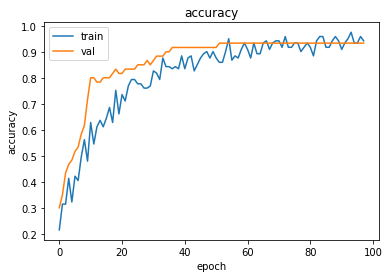

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

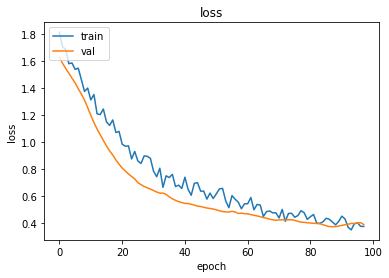

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluation

In [27]:
test_model = tf.keras.models.load_model('/content/PJ61403_ClassWeights_model_Ver2.h5')

In [28]:
num_test_files = len(test_generator.filenames)

In [29]:
test_generator.reset()

In [30]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## Confusion Matrix

### Without Normalize

Confusion matrix, without normalization
[[14  1  2  0]
 [ 0 15  0  0]
 [ 0  0 16  0]
 [ 0  0  0 15]]


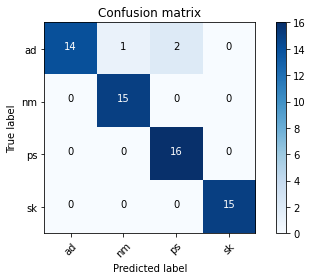

In [31]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['ad', 'nm', 'ps', 'sk']

plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[0.82352941 0.05882353 0.11764706 0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]]


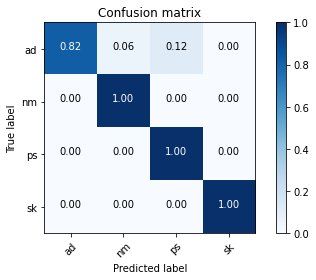

In [32]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [33]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[14  1  2  0]
 [ 0 15  0  0]
 [ 0  0 16  0]
 [ 0  0  0 15]]
Classification Report
              precision    recall  f1-score   support

          ad       1.00      0.82      0.90        17
          nm       0.94      1.00      0.97        15
          ps       0.89      1.00      0.94        16
          sk       1.00      1.00      1.00        15

    accuracy                           0.95        63
   macro avg       0.96      0.96      0.95        63
weighted avg       0.96      0.95      0.95        63



## TP FP FN TN

In [34]:
cm_2 = confusion_matrix(test_labels, y_pred)

### TP

In [35]:
TruePositive= np.diag(cm_2)

In [37]:
print(TruePositive)
sumTruePositive = sum(TruePositive)
print('Sum of True Positive: ', sumTruePositive)

### FP

In [42]:
FalsePositive = []
for i in range(NUM_CLASSES):
    FalsePositive.append(sum(cm_2[:,i]) - cm_2[i,i])

In [43]:
print(FalsePositive)
sumFalsePositive = sum(FalsePositive)
print('Sum of False Positive: ', sumFalsePositive)

[0, 1, 2, 0]
Sum of False Positive:  3


### FN

In [44]:
FalseNegative = []
for i in range(NUM_CLASSES):
    FalseNegative.append(sum(cm_2[i,:]) - cm_2[i,i])

In [45]:
print(FalseNegative)
sumFalseNegative = sum(FalseNegative)
print('Sum of False Negative: ', sumFalseNegative)

[3, 0, 0, 0]
Sum of False Negative:  3


### TN

In [46]:
TrueNegative = []
for i in range(NUM_CLASSES):
    temp = np.delete(cm_2, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))

In [47]:
print(TrueNegative)
sumTrueNegative = sum(TrueNegative)
print('Sum of True Negative: ', sumTrueNegative)

[46, 47, 45, 48]
Sum of True Negative:  186


### Check TP + FP +FN + TN = Test set

In [48]:
l = len(test_labels)
for i in range(NUM_CLASSES):
    print(TruePositive[i] + FalsePositive[i] + FalseNegative[i] + TrueNegative[i] == l)

True
True
True
True


## PYCM

In [49]:
!pip3 install pycm==3.0

     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 573kB 20.7MB/s 


In [50]:
from pycm import *

In [51]:
py_cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=y_pred)

In [52]:
py_cm.classes

[0, 1, 2, 3]

In [53]:
py_cm.table

{0: {0: 14, 1: 1, 2: 2, 3: 0},
 1: {0: 0, 1: 15, 2: 0, 3: 0},
 2: {0: 0, 1: 0, 2: 16, 3: 0},
 3: {0: 0, 1: 0, 2: 0, 3: 15}}

In [54]:
print(py_cm)

Predict  0        1        2        3        
Actual
0        14       1        2        0        

1        0        15       0        0        

2        0        0        16       0        

3        0        0        0        15       





Overall Statistics : 

95% CI                                                            (0.89979,1.00497)
ACC Macro                                                         0.97619
ARI                                                               0.87204
AUNP                                                              0.96831
AUNU                                                              0.97002
Bangdiwala B                                                      0.91019
Bennett S                                                         0.93651
CBA                                                               0.91248
CSI                                                               0.91248
Chi-Squared                                             

### Average AUC

In [56]:
AV_AUC = (py_cm.AUC[0] + py_cm.AUC[1] + py_cm.AUC[2] + py_cm.AUC[3])/len(py_cm.AUC)

In [57]:
print('Average AUC: ', AV_AUC)

Average AUC:  0.9700178608677514


### Average Senstivity

In [59]:
AV_Sens = (py_cm.TPR[0] + py_cm.TPR[1] + py_cm.TPR[2] + py_cm.TPR[3])/len(py_cm.TPR)

In [60]:
print('Average Sensitivity: ', AV_Sens)

Average Sensitivity:  0.9558823529411764


### Average Specificity

In [61]:
AV_Spec = (py_cm.TNR[0] + py_cm.TNR[1] + py_cm.TNR[2] + py_cm.TNR[3])/len(py_cm.TNR)

In [62]:
print('Average Specificity: ', AV_Spec)

Average Specificity:  0.9841533687943262


## Grad-CAM

In [66]:
last_conv2d = 'conv5_block16_2_conv'

### AD

In [67]:
ad_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/val/ad/ad1.jpg'

In [68]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, ad_img, layer_name=last_conv2d)

FileNotFoundError: ignored

### NM

In [ ]:
nm_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/test/nm/nm4.jpg'

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, nm_img, layer_name=last_conv2d)

### PS

In [ ]:
ps_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/val/ps/ps57.jpg'

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, ps_img, layer_name=last_conv2d)

### SK

In [ ]:
sk_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/test/sk/sk4.jpg'

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, sk_img, layer_name=last_conv2d)